In [1]:
import os
from pprint import pprint

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd

from pandas.io.json import json_normalize

%matplotlib inline

In [2]:
# Get Elasticsearch URL from environment variable
elasticsearch_url = os.environ['ELASTICSEARCH_URL']

# Create Elasticsearch client
client = Elasticsearch([elasticsearch_url])

# Make sure client can connect to Elasticsearch instance
client.info()

{'cluster_name': 'api-umbrella',
 'name': 'Hannibal King',
 'status': 200,
 'tagline': 'You Know, for Search',
 'version': {'build_hash': '00f95f4ffca6de89d68b7ccaf80d148f1f70e4d4',
  'build_snapshot': False,
  'build_timestamp': '2016-02-02T09:55:30Z',
  'lucene_version': '4.10.4',
  'number': '1.7.5'}}

In [19]:
search = Search(using=client)

In [20]:
total = search.count()
search = search[0:total]
results = search.execute()

In [21]:
len(results.hits.hits)

9634

In [22]:
results_df = json_normalize(results.hits.hits)

In [23]:
results_df.count()

_id                                    9634
_index                                 9634
_score                                 9634
_source.api_key                        5686
_source.backend_response_time          5987
_source.gatekeeper_denied_code          185
_source.internal_gatekeeper_time       9626
_source.proxy_overhead                 9626
_source.request_accept                 9376
_source.request_accept_encoding        5858
_source.request_at                     9634
_source.request_basic_auth_username       0
_source.request_connection             9562
_source.request_content_type           3851
_source.request_hierarchy              9634
_source.request_host                   9634
_source.request_ip                     9634
_source.request_ip_city                7165
_source.request_ip_country             9061
_source.request_ip_location               0
_source.request_ip_location.lat        9061
_source.request_ip_location.lon        9061
_source.request_ip_region       

In [24]:
results_df.columns

Index(['_id', '_index', '_score', '_source.api_key',
       '_source.backend_response_time', '_source.gatekeeper_denied_code',
       '_source.internal_gatekeeper_time', '_source.proxy_overhead',
       '_source.request_accept', '_source.request_accept_encoding',
       ...
       '_source.response_content_type', '_source.response_server',
       '_source.response_size', '_source.response_status',
       '_source.response_time', '_source.response_transfer_encoding',
       '_source.user_email', '_source.user_id',
       '_source.user_registration_source', '_type'],
      dtype='object', length=164)

In [25]:
# Convert request at column to date
#results_df['_source.request_at'] = pd.to_datetime(results_df['_source.request_at'])

In [26]:
results_df.index

RangeIndex(start=0, stop=9634, step=1)

In [27]:
results_df['request_date'] = pd.to_datetime(results_df['_source.request_at'], unit='ms')

In [28]:
results_df['request_date']

0      2016-09-29 10:28:36.516
1      2016-09-29 10:28:36.724
2      2016-09-29 10:21:57.558
3      2016-09-29 10:21:58.194
4      2016-09-29 10:28:58.039
5      2016-09-29 06:49:49.525
6      2016-09-29 11:32:54.275
7      2016-09-29 11:32:54.410
8      2016-09-29 06:56:47.073
9      2016-09-29 06:48:47.424
10     2016-09-29 06:48:44.795
11     2016-09-29 06:56:42.678
12     2016-09-13 09:25:01.540
13     2016-09-30 09:10:40.113
14     2016-09-29 13:01:19.266
15     2016-09-30 09:11:00.793
16     2016-09-29 13:01:16.282
17     2016-09-29 13:01:15.360
18     2016-09-29 13:01:15.492
19     2016-09-29 13:01:19.408
20     2016-09-29 13:17:17.887
21     2016-09-30 07:28:51.100
22     2016-09-30 07:26:26.904
23     2016-09-30 10:01:15.844
24     2016-09-30 10:01:15.855
25     2016-09-30 10:15:16.608
26     2016-09-30 10:15:16.612
27     2016-09-30 10:22:29.482
28     2016-09-30 10:22:29.627
29     2016-09-30 10:15:10.650
                 ...          
9604   2017-09-08 10:25:29.370
9605   2

In [29]:
results_df.set_index('request_date')

,_id,_index,_score,_source.api_key,_source.backend_response_time,_source.gatekeeper_denied_code,_source.internal_gatekeeper_time,_source.proxy_overhead,_source.request_accept,_source.request_accept_encoding,...,_source.response_content_type,_source.response_server,_source.response_size,_source.response_status,_source.response_time,_source.response_transfer_encoding,_source.user_email,_source.user_id,_source.user_registration_source,_type
request_date,,,,,,,,,,,,,,,,,,,,,
2016-09-29 10:28:36.516,aneluhs2e0v6bdrla8m0,api-umbrella-logs-v1-2016-09,1.0,None,NaN,None,0.0,0.0,*/*,"gzip, deflate, sdch, br",...,text/plain,openresty,65915,200,27,chunked,None,None,None,log
2016-09-29 10:28:36.724,aneluhtd44b8rugjt09g,api-umbrella-logs-v1-2016-09,1.0,1B5y1PD505Sk7XioTcxpjkEs464l2FX5xyX0mFT7,48.0,None,0.0,16.0,"application/json, text/javascript, */*; q=0.01","gzip, deflate, sdch, br",...,application/json; charset=utf-8,openresty,1729,200,64,chunked,web.admin.ajax@internal.apiumbrella,70a3c56f-5764-4a69-9b2a-c87aff573735,seed,log
2016-09-29 10:21:57.558,anelrgf08a2m5sbkdg3g,api-umbrella-logs-v1-2016-09,1.0,None,NaN,None,0.0,0.0,"text/html,application/xhtml+xml,application/xm...","gzip, deflate, sdch, br",...,text/html; charset=utf-8,openresty,2010,200,54,chunked,None,None,None,log
2016-09-29 10:21:58.194,anelrgjub01g1rgg7eu0,api-umbrella-logs-v1-2016-09,1.0,1B5y1PD505Sk7XioTcxpjkEs464l2FX5xyX0mFT7,44.0,None,10.0,13.0,"application/json, text/javascript, */*; q=0.01","gzip, deflate, sdch, br",...,application/json; charset=utf-8,openresty,1577,200,57,chunked,web.admin.ajax@internal.apiumbrella,70a3c56f-5764-4a69-9b2a-c87aff573735,seed,log
2016-09-29 10:28:58.039,anelun4ce90u077saj6g,api-umbrella-logs-v1-2016-09,1.0,None,NaN,None,0.0,0.0,*/*,"gzip, deflate, sdch, br",...,text/plain,openresty,65915,200,7,chunked,None,None,None,log
2016-09-29 06:49:49.525,aneiqcjvpf5729a4krm0,api-umbrella-logs-v1-2016-09,1.0,None,NaN,None,0.0,0.0,"text/html,application/xhtml+xml,application/xm...","gzip, deflate, sdch, br",...,text/html; charset=utf-8,openresty,1220,302,1750,chunked,None,None,None,log
2016-09-29 11:32:54.275,anemrvlrnqrkqb9up5b0,api-umbrella-logs-v1-2016-09,1.0,8Uq3GR9mHiTrazBlEnNyGAfCNlPXULakC6s17ka2,131.0,None,0.0,3.0,application/json,None,...,application/json; charset=utf-8,openresty,2280,201,149,None,nightly@apinf.io,844433ba-5dfd-4734-af0d-09bd40636660,web,log
2016-09-29 11:32:54.410,anemrvn9c7h0osp9tu80,api-umbrella-logs-v1-2016-09,1.0,8Uq3GR9mHiTrazBlEnNyGAfCNlPXULakC6s17ka2,78.0,None,0.0,9.0,application/json,None,...,application/json; charset=utf-8,openresty,3802,201,101,None,nightly@apinf.io,844433ba-5dfd-4734-af0d-09bd40636660,web,log
2016-09-29 06:56:47.073,aneitivkqt3vgar2369g,api-umbrella-logs-v1-2016-09,1.0,None,NaN,None,0.0,0.0,"text/html,application/xhtml+xml,application/xm...","gzip, deflate, sdch, br",...,text/html; charset=utf-8,openresty,2029,200,15,chunked,None,None,None,log


# Visualize

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

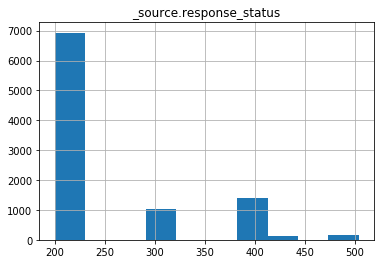

In [30]:
pd.DataFrame.hist(results_df, column='_source.response_status').plot()